In [1]:
! pip install torch torchvision datasets pillow
! pip install onnx onnx-tf tensorflow
! pip install torch torchvision pillow scikit-learn kaggle --quiet
! pip install tensorflow opencv-python-headless matplotlib scikit-learn --quiet
! pip install --upgrade pip
! pip install "numpy<2.0" --upgrade --quiet


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
streamlit 1.28.2 requires numpy<2,>=1.19.3, but you have numpy 2.2.6 which is incompatible.
streamlit 1.28.2 requires packaging<24,>=16.8, but you have packaging 24.2 which is incompatible.
numba 0.57.0 requires numpy<1.25,>=1.21, but you have numpy 2.2.6 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
streamlit 1.28.2 requires packaging<24,>=16.8, but you have packaging 24.2 which is incompatible.
numba 0.57.0 requires numpy

In [2]:
import os, json
with open('kaggle.json') as f:
    cred = json.load(f)
os.environ['KAGGLE_USERNAME'] = cred['username']
os.environ['KAGGLE_KEY']     = cred['key']


In [3]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os

api = KaggleApi(); api.authenticate()

os.makedirs('data/stroke', exist_ok=True)
api.dataset_download_files(
    'danish003/face-images-of-acute-stroke-and-non-acute-stroke',
    path='data/stroke', unzip=True
)


Dataset URL: https://www.kaggle.com/datasets/danish003/face-images-of-acute-stroke-and-non-acute-stroke


In [2]:
# Cell 2: imports & paths
import os, cv2, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras

# adjust this path if needed
base_dir      = 'data/stroke/main'
stroke_dir    = os.path.join(base_dir, 'stroke_data')
no_stroke_dir = os.path.join(base_dir, 'noStroke_data')

IMG_W, IMG_H = 150, 150



In [3]:
# Cell 3: load & label images
images, labels = [], []

def load_folder(folder, label):
    for fn in os.listdir(folder):
        fp = os.path.join(folder, fn)
        img = cv2.imread(fp)
        if img is None: continue
        img = cv2.resize(img, (IMG_W, IMG_H))
        images.append(img)
        labels.append(label)

load_folder(stroke_dir,    1)  # acute stroke = 1
load_folder(no_stroke_dir, 0)  # non‑acute = 0

print(f"Loaded {len(images)} samples → Stroke: {sum(labels)}, Non‑Stroke: {len(labels)-sum(labels)}")






Loaded 3770 samples → Stroke: 1259, Non‑Stroke: 2511


In [4]:
# Cell 4: array conversion & normalization
X = np.array(images, dtype='float32') / 255.0
y = np.array(labels, dtype='int32')


In [5]:
# Cell 5: train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Shapes →",
      "train:", X_train.shape,
      "val:", X_val.shape,
      "test:", X_test.shape)


Shapes → train: (2639, 150, 150, 3) val: (565, 150, 150, 3) test: (566, 150, 150, 3)


In [7]:
# Cell 6: build the CNN
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_W,IMG_H,3)),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 64)        0

In [8]:
# Cell 7: compile & train
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)


Epoch 1/10
83/83 [==============================] - 12s 140ms/step - loss: 0.6477 - accuracy: 0.6908 - val_loss: 0.4948 - val_accuracy: 0.7381
Epoch 2/10
83/83 [==============================] - 11s 138ms/step - loss: 0.4885 - accuracy: 0.7783 - val_loss: 0.4416 - val_accuracy: 0.8301
Epoch 3/10
83/83 [==============================] - 12s 139ms/step - loss: 0.3623 - accuracy: 0.8556 - val_loss: 0.3357 - val_accuracy: 0.8920
Epoch 4/10
83/83 [==============================] - 12s 139ms/step - loss: 0.2680 - accuracy: 0.8984 - val_loss: 0.3109 - val_accuracy: 0.8619
Epoch 5/10
83/83 [==============================] - 12s 140ms/step - loss: 0.2392 - accuracy: 0.9060 - val_loss: 0.3125 - val_accuracy: 0.8761
Epoch 6/10
83/83 [==============================] - 12s 140ms/step - loss: 0.1545 - accuracy: 0.9451 - val_loss: 0.1877 - val_accuracy: 0.9239
Epoch 7/10
83/83 [==============================] - 12s 140ms/step - loss: 0.1196 - accuracy: 0.9534 - val_loss: 0.1509 - val_accuracy: 0.9416

In [9]:
# Cell: Save Keras model
model.save('stroke_model.h5')
print("✅ Model saved to stroke_model.h5")


✅ Model saved to stroke_model.h5


/Users/ashwathkarunakaram/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
# Cell: Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")


Test loss: 0.1285, Test accuracy: 0.9558


1/1 [==============================] - 0s 51ms/step


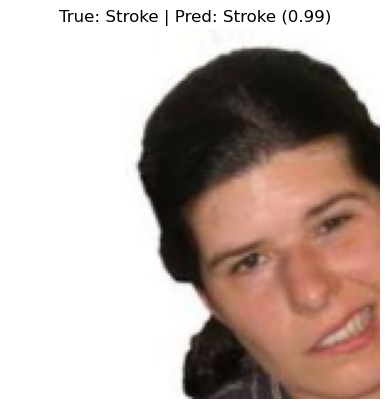

1/1 [==============================] - 0s 12ms/step


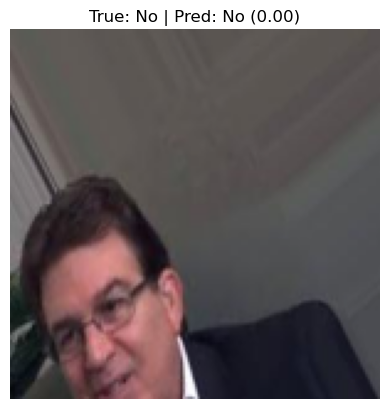

1/1 [==============================] - 0s 11ms/step


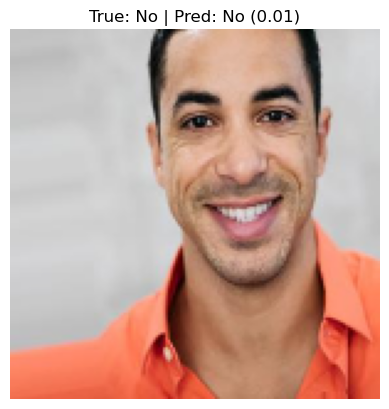

In [11]:
# Cell: Quick random‐sample sanity check
import random
import matplotlib.pyplot as plt
import cv2

for _ in range(3):
    idx = random.randrange(len(X_test))
    img, true = X_test[idx], y_test[idx]
    pred = model.predict(img[None,...])[0][0]
    plt.imshow(cv2.cvtColor((img*255).astype('uint8'), cv2.COLOR_BGR2RGB))
    plt.title(f"True: {'Stroke' if true else 'No'} | Pred: {'Stroke' if pred>=0.5 else 'No'} ({pred:.2f})")
    plt.axis('off')
    plt.show()


In [12]:
# Cell: Convert to TFLite
import tensorflow as tf

keras_model = tf.keras.models.load_model('stroke_model.h5', compile=False)
converter   = tf.lite.TFLiteConverter.from_keras_model(keras_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
open('stroke_model.tflite','wb').write(tflite_model)
print("✅ Exported stroke_model.tflite")


INFO:tensorflow:Assets written to: /var/folders/hc/b90l6brj1bv5_ccssjgkh30m0000gn/T/tmp3zovbu5l/assets


INFO:tensorflow:Assets written to: /var/folders/hc/b90l6brj1bv5_ccssjgkh30m0000gn/T/tmp3zovbu5l/assets


✅ Exported stroke_model.tflite


2025-07-18 07:10:45.322311: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-07-18 07:10:45.322322: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-07-18 07:10:45.322547: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/hc/b90l6brj1bv5_ccssjgkh30m0000gn/T/tmp3zovbu5l
2025-07-18 07:10:45.323410: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-07-18 07:10:45.323416: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/hc/b90l6brj1bv5_ccssjgkh30m0000gn/T/tmp3zovbu5l
2025-07-18 07:10:45.324787: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2025-07-18 07:10:45.325411: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-07-18 07:10:45.356971: I tensorflow/cc/saved_model/loader.

In [13]:
# Cell: TFLite inference check
import numpy as np
import tensorflow as tf

# Load interpreter
interpreter = tf.lite.Interpreter(model_path='stroke_model.tflite')
interpreter.allocate_tensors()
inp_details  = interpreter.get_input_details()[0]
out_details = interpreter.get_output_details()[0]

# Pick one test sample
x = X_test[0:1].astype(np.float32)
interpreter.set_tensor(inp_details['index'], x)
interpreter.invoke()
p = interpreter.get_tensor(out_details['index'])[0][0]
print("TFLite Prediction:", p, "→", "Stroke" if p>=0.5 else "No Stroke")


TFLite Prediction: 0.0017226621 → No Stroke


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
